### Setup

In [1]:
!git clone https://github.com/rohaldb/NSFF-custom
!mv NSFF-custom Neural-Scene-Flow-Fields

Cloning into 'NSFF-custom'...
remote: Enumerating objects: 743, done.
remote: Counting objects: 100% (743/743), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 743 (delta 425), reused 684 (delta 366), pack-reused 0
Receiving objects: 100% (743/743), 99.68 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (425/425), done.


In [2]:
%cd /content/Neural-Scene-Flow-Fields
!pip install -r requirements.txt

/content/Neural-Scene-Flow-Fields
     |████████████████████████████████| 37.2 MB 58 kB/s 


In [ ]:
#download data
%cd /content/
!gdown https://drive.google.com/uc?id=1wm7D68vDBctDwsTLfevvZM5wEiIp9cLR
!unzip "custom_nerf_data.zip"; rm "custom_nerf_data.zip";

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Training a new model
Unfortunately there is no good way to download the images off tensorboard. So best way to do it is just to drag them to desktop and upload to google drive

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/Neural-Scene-Flow-Fields/nsff_exp/logs/summaries

In [5]:
txt = """
expname = kid-running_ndc_5f_sv_of_sm_unify3_testing-{}

basedir = ./logs
datadir = /content/nerf_data/kid-running/dense

dataset_type = llff

factor = 2
llffhold = 10

N_rand = 1024
N_samples = 128
N_importance = 0
netwidth = 256

use_viewdirs = True
raw_noise_std = 1e0
no_ndc = False
lindisp = False
no_batching = True
spherify = False
decay_depth_w = True
decay_optical_flow_w = True
use_motion_mask = True
num_extra_sample = 512
decay_iteration = 30

w_depth = 0.04
w_optical_flow = 0.02
w_sm = 0.1
w_sf_reg = 0.01
w_cycle = 1.0
w_prob_reg = 0.1

start_frame = 8
end_frame = 11
"""

In [6]:
%cd /content/Neural-Scene-Flow-Fields/nsff_exp
for j in [10]:
  with open("/content/Neural-Scene-Flow-Fields/nsff_exp/configs/config_kid-running.txt", "w") as text_file:
    text_file.write(txt.format(j))
  # !python run_nerf.py --config configs/config_kid-running.txt --target_idx 1 --i_weights 2500 --i_img 2500 --i_vid 5000 --i_print 100 --w_sf {j} 

/content/Neural-Scene-Flow-Fields/nsff_exp


In [ ]:
while True:
  pass

In [ ]:
#copy results to google drive
%cp -R /content/Neural-Scene-Flow-Fields/nsff_exp/logs/* "/content/drive/MyDrive/Thesis/sf reg/nsff"
%ls "/content/drive/MyDrive/Thesis/sf reg/nsff"

###Rendering from my pretrained model

In [22]:
!rm -rf /content/Neural-Scene-Flow-Fields/nsff_exp/logs

In [23]:
%cd /content/Neural-Scene-Flow-Fields/nsff_exp
!mkdir -p "./logs/"
%cp -R "/content/drive/MyDrive/Thesis/NSFF/." ./logs

/content/Neural-Scene-Flow-Fields/nsff_exp


In [ ]:
%%time
!python run_nerf.py --config configs/config_kid-running.txt --target_idx 1 --render_single_frame

In [ ]:
%%time
!python run_nerf.py --config configs/config_kid-running.txt --target_idx 1 --render_lockcam_slowmo

In [ ]:
%%time
!python run_nerf.py --config configs/config_kid-running.txt --render_bt --bt_linear_interpolation --target_idx 1

## Messing Around

In [19]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import torch
from run_nerf_helpers import *

red region mean [0.02336677 0.0826009  0.02065787]
blue region mean [0.3826554  0.09920079 0.07259405]


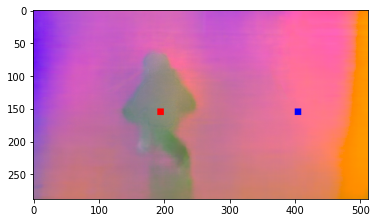

In [ ]:
sf = np.load("/content/Neural-Scene-Flow-Fields/nsff_exp/sf_fwd_cam.npy")
img = compute_color_sceneflow(torch.tensor(sf))
sf = np.absolute(sf)
print("red region mean", sf[150:160, 190:200].mean(axis=(0,1)))
img[150:160, 190:200] = [255, 0, 0]

print("blue region mean", sf[150:160, 400:410].mean(axis=(0,1)))
img[150:160, 400:410] = [0, 0, 255]

plt.imshow(img);

red region mean [0.02420608 0.08329991 0.01645493]
blue region mean [0.34446174 0.09016486 0.07378996]


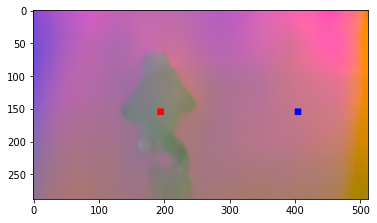

In [ ]:
sf = np.load("/content/nerf_data/kid-running/dense/sf/00009.npy")

img = compute_color_sceneflow(torch.tensor(sf))
sf = np.absolute(sf)
print("red region mean", sf[150:160, 190:200].mean(axis=(0,1)))
img[150:160, 190:200] = [255, 0, 0]

print("blue region mean", sf[150:160, 400:410].mean(axis=(0,1)))
img[150:160, 400:410] = [0, 0, 255]

plt.imshow(img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


red region mean [ 4.933465 13.368211]
blue region mean [166.00758  40.21666]


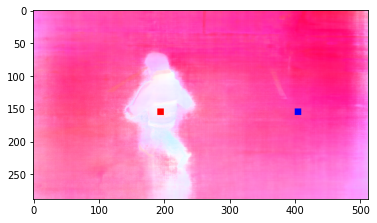

In [ ]:
sf = np.load("/content/Neural-Scene-Flow-Fields/nsff_exp/opt_fwd.npy")
img = flow_to_image(sf) / 255.
sf = np.absolute(sf)
print("red region mean", sf[150:160, 190:200].mean(axis=(0,1)))
img[150:160, 190:200] = [255, 0, 0]

print("blue region mean", sf[150:160, 400:410].mean(axis=(0,1)))
img[150:160, 400:410] = [0, 0, 255]

plt.imshow(img);

-------------------

In [10]:
def convert_pose_to_extrinsic(pose):
  R_w2c = pose[:3, :3].T
  t_w2c = -R_w2c @ pose[:3, 3:]
  return np.hstack((R_w2c, t_w2c))

def apply_transformation(matrix, point):
  hom_point = np.concatenate((point, [1]))
  hom_res = matrix @ hom_point
  return hom_res[:3]/hom_res[-1]

cOne2w = np.array([[ 1.0000000e+00, -2.0316549e-04, -2.3623972e-05, -3.2738742e-05],
       [ 2.0316640e-04,  1.0000000e+00,  6.9259913e-05, -1.3305638e-04],
       [ 2.3607043e-05, -6.9263318e-05,  1.0000000e+00, -3.0704503e-04]])
cOne2w = np.vstack((cOne2w, np.array([0,0,0,1])))

cTwo2w = np.array([[ 0.99996346, -0.0017747 ,  0.00836416, -0.01205349],
       [ 0.00179772,  0.9999946 , -0.00274637,  0.00185966],
       [-0.00835925,  0.0027613 ,  0.99996126, -0.00383185]]) 
cTwo2w = np.vstack((cTwo2w, np.array([0,0,0,1])))

w2cTwo = convert_pose_to_extrinsic(cTwo2w)
w2cTwo = np.vstack((w2cTwo, np.array([0,0,0,1])))

hwf = np.array([288.     , 512.     , 502.22906])
K = np.eye(3)
K[0, 0] = hwf[2]
K[0, 2] = hwf[1] / 2. 
K[1, 1] = hwf[2]
K[1, 2] = hwf[0] / 2.

In [11]:
#sanity check that going cam2world and then world2cam is same point
point = np.array([1,1,1])
z = apply_transformation(cTwo2w, point)
point_hat = apply_transformation(w2cTwo, z)
assert np.all(np.isclose(point, point_hat))

In [13]:
sf = np.load("/content/nerf_data/kid-running/dense/sf/00009.npy")
depth = np.load("/content/nerf_data/kid-running/dense/depth_0/00009.npy")

def homogeneous(vec):
  return np.concatenate((vec, [1]))

sf_result = np.zeros_like(sf)
S_cam = np.zeros_like(sf)
for y in range(sf.shape[0]):
  for x in range(sf.shape[1]):
    p = [y,x]
    # P is in cam1 space
    P_c1 = (np.linalg.inv(K) @ homogeneous(p)) * depth[y, x]
    # convert to cam2's space
    P_w = apply_transformation(cOne2w, P_c1)
    P_c2 = apply_transformation(w2cTwo, P_w)
    # obtain ego-motion induced sf due to camera coordinate differences
    S_cam[y,x] = P_c2 - P_c1
    # subtract ego-motion sf from sf estimates
    sf_result[y,x] = sf[y,x] - S_cam[y,x]

In [22]:
plt.imshow(compute_color_sceneflow(torch.tensor(S_cam)))

(array([[0.29739225, 0.03046423, 0.28487357],
        [0.30050552, 0.0320852 , 0.28725117],
        [0.3036188 , 0.03370616, 0.2896288 ],
        [0.30673203, 0.03532713, 0.2920064 ],
        [0.30984527, 0.0369481 , 0.294384  ]], dtype=float32),
 array([[-0.23817913,  0.10102556, -0.09580918],
        [-0.25363588,  0.10729624, -0.10144945],
        [-0.2711282 ,  0.11439272, -0.10783251],
        [-0.29108638,  0.1224896 , -0.1151154 ],
        [-0.31407154,  0.13181448, -0.12350283]], dtype=float32),
 array([[ 0.5355714 , -0.07056133,  0.38068277],
        [ 0.5541414 , -0.07521104,  0.38870063],
        [ 0.57474697, -0.08068655,  0.39746132],
        [ 0.5978184 , -0.08716247,  0.4071218 ],
        [ 0.6239168 , -0.09486638,  0.41788682]], dtype=float32))

red region mean [0.09254501 0.03597644 0.01153177]
blue region mean [0.5012442  0.0218343  0.00595219]


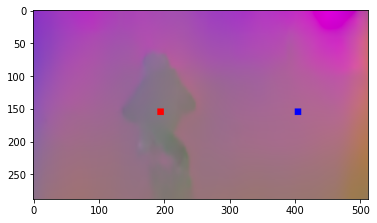

In [ ]:
sf = sf_result
img = compute_color_sceneflow(torch.tensor(sf))
sf = np.absolute(sf)
print("red region mean", sf[150:160, 190:200].mean(axis=(0,1)))
img[150:160, 190:200] = [255, 0, 0]

print("blue region mean", sf[150:160, 400:410].mean(axis=(0,1)))
img[150:160, 400:410] = [0, 0, 255]

plt.imshow(img);

red region mean [0.02420608 0.08329991 0.01645493]
blue region mean [0.34446174 0.09016486 0.07378996]


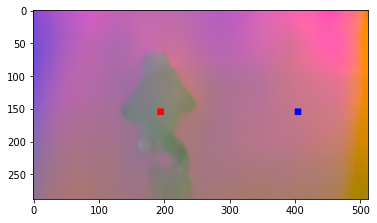

In [ ]:
sf = np.load("/content/nerf_data/kid-running/dense/sf/00009.npy")
img = compute_color_sceneflow(torch.tensor(sf))
sf = np.absolute(sf)
print("red region mean", sf[150:160, 190:200].mean(axis=(0,1)))
img[150:160, 190:200] = [255, 0, 0]

print("blue region mean", sf[150:160, 400:410].mean(axis=(0,1)))
img[150:160, 400:410] = [0, 0, 255]

plt.imshow(img);

In [ ]:
poses = np.load("/content/nerf_data/kid-running/dense/poses_bounds.npy")
poses = poses[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
poses[:3,:3, 9], poses[:, -2, 9]

(array([[-0.03818854,  0.98934593, -0.14048583],
        [ 0.99926064,  0.03718275, -0.00977822],
        [-0.00445039, -0.14075537, -0.9900344 ]]),
 array([ 4.6682393 ,  0.68745059, -1.76943407]))